In [1]:
%pip install -U albumentations timm tqdm scikit-learn ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 97.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/20

In [2]:
import os
import sys
import cv2
import random
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from tqdm import tqdm
import timm
from timm.data.mixup import Mixup
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts, LinearLR, SequentialLR
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from IPython.display import display
import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO
from torch.amp import autocast, GradScaler
pd.set_option('display.max_rows', None)  # Hiển thị tất cả dòng
pd.set_option('display.max_columns', None)  # Hiển thị tất cả cột
pd.set_option('display.expand_frame_repr', False)  # Ngăn pandas cắt dòng
pd.set_option('display.max_colwidth', None)  # Không giới hạn độ rộng của cột
print(torch.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
2.5.1+cu124


In [6]:
class PrepareData:
    ######
    # Khởi tạo phần tử nhận vào đường dẫn dataset
    # Lưu lại đường dẫn folder train, val, test
    # Nếu nếu đã chuẩn hóa dữ liệu trước đó rồi thì check_aug = True và thay thế train và val
    # bằng đường dẫn ảnh đã tăng cường
    # Nếu không thì check_aug = False và giữ nguyên đường dẫn train, val, test

    def __init__(self, dataset_path, output_path=None, check_aug=False):
        self.train_path = os.path.join(dataset_path, 'train')
        self.val_path = os.path.join(dataset_path, 'val')
        self.test_path = os.path.join(dataset_path, 'test')
        self.output_path = output_path

        if self.output_path == None:
            self.output_path = dataset_path

        if check_aug == True:
            # Tạo đường dẫn cho thư mục ảnh tăng cường
            aug_train_path = os.path.join(self.output_path, 'aug_dataset', 'aug_train')
            aug_val_path = os.path.join(self.output_path, 'aug_dataset', 'aug_val')

            # Kiểm tra các thư mục đã có sẵn hay chưa, nếu có sẽ thay làm folder cho training
            if not os.path.exists(aug_train_path):
                raise ValueError(f"Error: The 'aug_train' directory is missing in {self.base_dir}")
            else:
                self.train_path = aug_train_path

    ######
    # Hàm đếm số lượng ảnh của từng class trong các thư mục train, val, test
    def num_data(self):
        paths = [
            self.train_path,
            self.val_path,
            self.test_path
        ]
        for i in paths:
            temp = []
            for class_folder in os.listdir(i):
                class_path = os.path.join(i, class_folder)
                if os.path.isdir(class_path):
                    num_images = len(os.listdir(class_path))
                    temp.append((class_folder, num_images))
            
            sum = 0
            for j in temp:
                sum += j[1]
            print(f"Total number of images in {os.path.basename(os.path.normpath(i))}: {sum}")
            print(pd.DataFrame(temp, columns=['Class', 'Number of Images']))

    ######
    # Hàm tăng cường dữ liệu đầu vào
    # Nhận vào các phép biến đổi từ albumentations
    # class_rules là một dictionary chứa số lượng ảnh cần tạo thêm cho mỗi lớp chỉ định
    # Nếu không có class_rules thì sẽ sử dụng mặc định là 5 cho VT, LT, 3 cho NC, NNA và 0 cho NNU
    # các lớp còn lại sẽ là 1
    # Sau khi hoàn thành sẽ tạo ra 2 thư mục aug_train và aug_val trong thư mục aug_dataset
    # và lưu ảnh đã tăng cường vào đó
    # Thay thế đường dẫn cho train và val bằng đường dẫn mới        
    def augment_data(self, augmentations, class_rules=None):
        # Kiểm tra xem các thư mục aug_train và aug_val có tồn tại không, nếu không thì tạo mới
        base_dir = self.output_path
        # Check folder aug_dataset
        try:
            os.mkdir(os.path.join(base_dir, 'aug_dataset'))
        except Exception as e:
            print(f"Error creating aug_dataset directory: {e}")
        try: 
            # Tạo folder aug_train và aug_val trong folder aug_dataset
            aug_train_path = os.path.join(base_dir, 'aug_dataset', 'aug_train')
            aug_val_path = os.path.join(base_dir, 'aug_dataset', 'aug_val')
            os.makedirs(aug_train_path)
            os.makedirs(aug_val_path)
        except Exception as e:
            print(f"Error creating aug_train and aug_val directories: {e}")
            return

        # Class rules mặc định nếu không có
        # Dựa vào số lượng dữ liệu hiện tại để quyết định số lượng ảnh cần tạo thêm cho mỗi lớp
        # Ở đây, đối với mỗi ảnh sẽ tạo thêm x ảnh tăng cường
        if class_rules is None:
            class_rules = {
                "VT": 5,
                "LT": 5,
                "NC": 3,
                "NNA": 3,
                "NNU": 0,
            }

        input_path = [self.train_path] # self.val_path
        output_path = [aug_train_path] # aug_val_path

        for index, pth in enumerate(input_path):
            for class_folder in os.listdir(pth):
                # Số lượng ảnh tăng cường cho mỗi lớp, nếu không có sẽ gán là 1
                n = class_rules.get(class_folder, 1)
                class_path = os.path.join(pth, class_folder)
                # Tạo thư mục class để lưu ảnh vào output có index tương tự
                save_path = os.path.join(output_path[index], class_folder)

                # Kiểm tra xem thư mục đã tồn tại chưa, nếu không thì tạo mới
                try:
                    os.makedirs(save_path)
                except Exception as e:
                    print(f"Error creating directory {save_path}: {e}")
                    return
            
                # Lặp qua tất cả các ảnh trong thư mục class
                # Đọc ảnh và áp dụng các phép biến đổi
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Error reading image {img_path}")
                        return
                    cv2.imwrite(os.path.join(save_path, f"original_{img_name}"), img=img)

                    # Chuyển đổi ảnh từ BGR sang RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Lưu ảnh gốc vào thư mục
                    for j in range(n):
                        # Áp dụng các phép biến đổi
                        augmented = augmentations(image=img)
                        augmented_image = augmented['image']
                        # Tạo tên ảnh mới với số thứ tự và lưu vào thư mục
                        cv2.imwrite(os.path.join(save_path, f"aug_{j}_{img_name}"), cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

        # Sau khi hoàn thành, in ra thông báo và lưu lại đường dẫn
        print("Augmentation completed successfully!")
        self.train_path = aug_train_path
        # self.val_path = aug_val_path

    ######
    # Hàm tính toán mean và std để chuẩn hóa dữ liệu
    # Đọc tất cả ảnh trong 2 thư mục train và val
    # Tính toán mean và std cho tất cả ảnh trong thư mục
    # Lưu lại mean và std vào biến self.mean và self.std
    def compute_mean_std(self):
        mean = np.zeros(3)
        std = np.zeros(3)
        num = 0

        image_paths = []

        # Đọc tất cả ảnh có trong 2 thư mục train và val
        for i in [self.train_path]:
            for subdir, _, files in os.walk(i):
                for file in files:
                    if file.endswith(('.jpg', '.jpeg', '.png')):
                        image_paths.append(os.path.join(subdir, file))
                    
        # Tính toán mean và std cho tất cả ảnh trong thư mục
        for img_path in tqdm(image_paths, desc="Processing images: "):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            mean += np.mean(img, axis=(0, 1))
            std += np.std(img, axis=(0, 1))
            
        num = len(image_paths)
        self.mean = mean / num
        self.std = std / num
        print(f"Mean: {self.mean}, Std: {self.std}")


    ######
    # Chuẩn hóa dữ liệu
    # Nhận vào các phép biển đổi của từng tập
    # Lưu trữ dữ liệu vào các biến train_data, val_data, test_data
    # In ra danh sách các class và index
    def standardize_data(self, train_transforms, val_transforms, test_transforms):        
        self.train_data = datasets.ImageFolder(self.train_path, transform=train_transforms)
        self.val_data = datasets.ImageFolder(self.val_path, transform=val_transforms)
        self.test_data = datasets.ImageFolder(self.test_path, transform=test_transforms)
        print("Data are saved to self.train_data, self.val_data, self.test_data")
                                             

        print(self.train_data.class_to_idx)

## Progressive unfreeze training


In [7]:
class ModelTrainer:
    def __init__(self, model, train_data, val_data, criterion, optimizer, scheduler, device, num_epochs=50, batch_size=32, patience=5, checkpoint_path=None, log_dir=None):
        self.model = model
        self.train_data = train_data
        self.val_data = val_data
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.patience = patience
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.best_weights = None
        self.checkpoint_path = checkpoint_path
        self.log_dir = log_dir
        self.writer = None
        self.mixup = Mixup(mixup_alpha=0.4, cutmix_alpha=1.0, num_classes=8)

        if log_dir:
            try:
                from torch.utils.tensorboard import SummaryWriter
                self.writer = SummaryWriter(log_dir)
            except ImportError:
                print("TensorBoard is not installed. Logging disabled.")

    # def progressive_unfreeze(self, epoch):
    #     if not hasattr(self.model, "blocks"):
    #         return
    #     group_size = 4
    #     total_blocks = len(self.model.blocks)
    #     unfreeze_until = min(total_blocks, (epoch // 3 + 1) * group_size)
    #     print("Unfreeze từ lớp đầu tiên cho đến ", unfreeze_until)

    #     for i, blk in enumerate(self.model.blocks):
    #         requires_grad = i >= total_blocks - unfreeze_until
    #         for param in blk.parameters():
    #             param.requires_grad = requires_grad
                
    #     for param in self.model.head.parameters():
    #         param.requires_grad = True


    def progressive_unfreeze(self, epoch):
        if not hasattr(self.model, "layers"):
            return
        group_size = 1  # bạn có thể tinh chỉnh
        total_layers = len(self.model.layers)
        unfreeze_until = min(total_layers, (epoch // 5 + 1) * group_size)
        print("Unfreeze từ layer đầu tiên đến", unfreeze_until)
    
        for i, layer in enumerate(self.model.layers):
            requires_grad = i >= total_layers - unfreeze_until
            for param in layer.parameters():
                param.requires_grad = requires_grad
    
        # Luôn unfreeze head (phần classifier cuối cùng)
        if hasattr(self.model, "head"):
            for param in self.model.head.parameters():
                param.requires_grad = True

    
    def train_epoch(self, train_loader, epoch):
        self.model.train()
        running_loss = 0.0
        total_images = len(self.train_data)
        processed_images = 0
        scaler = GradScaler() 
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device) 
            inputs, labels = self.mixup(inputs, labels)
            self.optimizer.zero_grad() 
            with autocast(device_type='cuda'): 
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            scaler.step(self.optimizer)
            scaler.update()
            running_loss += loss.detach().item() * inputs.size(0)
            processed_images += inputs.size(0)
            sys.stdout.write(f"\rEpoch [{epoch+1}/{self.num_epochs}], Progress: {processed_images}/{total_images} ({100 * processed_images / total_images:.2f}%)")
            sys.stdout.flush()
        epoch_loss = running_loss / processed_images 
        self.train_losses.append(epoch_loss) 
        print(f"\nEpoch [{epoch+1}/{self.num_epochs}], Train Loss: {epoch_loss:.4f}")
        if self.writer:
            self.writer.add_scalar('Train/Loss', epoch_loss, epoch)
            
    def validate_epoch(self, val_loader, epoch):
        self.model.eval()  
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                val_loss += loss.detach().item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss /= total
        accuracy = correct / total
        self.val_losses.append(val_loss)
        self.val_accuracies.append(accuracy)
        print(f"Epoch [{epoch+1}/{self.num_epochs}], Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
        print("------------")
        if self.writer:
            self.writer.add_scalar('Val/Loss', val_loss, epoch)
            self.writer.add_scalar('Val/Accuracy', accuracy, epoch)
        return val_loss
        
    def train(self):
        train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=4)
        best_val_loss = float('inf')
        counter = 0 
        for epoch in range(self.num_epochs): 
            self.progressive_unfreeze(epoch)
            self.train_epoch(train_loader, epoch) 
            val_loss = self.validate_epoch(val_loader, epoch) 

            if isinstance(self.scheduler, ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            elif isinstance(self.scheduler, CosineAnnealingWarmRestarts) or isinstance(self.scheduler, CosineAnnealingLR):
                self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch + 1}/{self.num_epochs} - Learning Rate: {current_lr}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.best_weights = self.model.state_dict()
                if self.checkpoint_path:
                    torch.save(self.best_weights, self.checkpoint_path)
                    print(f"Best model saved to {self.checkpoint_path}")
                print("Save best weights!")
                counter = 0  
            else:
                counter += 1
                print(f"Early Stopping Counter: {counter}/{self.patience}")
                if counter >= self.patience:
                    print("Early Stopping Triggered. Stopping Training.")
                    break
            print("--------------------")
        print("------------------------")
        self.model.load_state_dict(self.best_weights)
        print("Load best weights!")
        print("Model is saved to self.model")
        if self.writer:
            self.writer.close()
        return 

    ######
    # Vẽ plot cho train_loss, val_loss và val_accuracy
    def training_plot(self):
        fig, axes = plt.subplots(1, 2, figsize=(24, 4))

        # Vẽ loss
        axes[0].plot(self.train_losses, label='Train Loss')
        axes[0].plot(self.val_losses, label='Validation Loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].set_title('Training and Validation Loss')
        
        # Vẽ accuracy
        axes[1].plot(self.val_accuracies, label='Validation Accuracy', color='green')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].set_title('Validation Accuracy')
        
        plt.show()
        return

    #######
    # Hàm đánh giá mô hình trên tập test
    def evaluate_model(self, data, external_model=None):
        test_loader = DataLoader(data.test_data, batch_size=self.batch_size, shuffle=False, num_workers=4)
        class_names = data.test_data.classes

        # Chuyển về chế độ đánh giá
        if external_model == None:
            model = self.model.eval()
        else:
            model = external_model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Dự đoán
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        # Chuyển về numpy array
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Tính toán các chỉ số đánh giá
        overall_accuracy = accuracy_score(all_labels, all_preds)
        overall_precision = precision_score(all_labels, all_preds, average='macro')
        overall_recall = recall_score(all_labels, all_preds, average='macro')
        overall_f1 = f1_score(all_labels, all_preds, average='macro')

        overall_metrics = {
            "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
            "Value": [overall_accuracy, overall_precision, overall_recall, overall_f1]
        }

        class_metrics = {
            "Class": [],
            "Precision": [],
            "Recall": []
        }
        
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        for class_name, metrics in report.items():
            if class_name in class_names:  # Bỏ qua 'accuracy' chung của classification_report
                class_metrics["Class"].append(class_name)
                class_metrics["Precision"].append(metrics['precision'])
                class_metrics["Recall"].append(metrics['recall'])

        
        df_overall = pd.DataFrame(overall_metrics)
        df_class = pd.DataFrame(class_metrics)

        print(df_overall)
        print(df_class)
        return

    ######
    # Hiển thị dự đoán x ảnh bất kỳ trong tập test
    def test_random_images(self, data, num_imgs=10):
        test_data = data.test_data
        class_names = test_data.classes  # Danh sách các lớp từ folder

        # Chọn ngẫu nhiên num_samples ảnh từ tập test
        indices = random.sample(range(len(test_data)), num_imgs)
        samples = [test_data[i] for i in indices]  # Lấy ảnh và label tương ứng

        # Chuẩn bị dữ liệu để dự đoán
        images = torch.stack([sample[0] for sample in samples])  # Ghép thành batch
        labels = [sample[1] for sample in samples]  # Nhãn thực tế

        # Chuyển sang device
        images = images.to(self.device)

        # Dự đoán
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(images)
            _, preds = torch.max(outputs, 1)  # Lấy class có xác suất cao nhất

        preds = preds.cpu().numpy()
        labels = np.array(labels)

        # Lưu kết quả vào DataFrame
        results = {
            "Index": indices,
            "Actual": [class_names[label] for label in labels],
            "Predicted": [class_names[pred] for pred in preds]
        }
        df_results = pd.DataFrame(results)

        # Hiển thị ảnh và dự đoán
        cols = min(num_imgs, 5)  # Số cột tối đa là 5
        rows = (num_imgs + cols - 1) // cols  # Số hàng cần thiết
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

        for i, (sample, ax) in enumerate(zip(samples, axes)):
            img = sample[0].permute(1, 2, 0).cpu().numpy()  # Chuyển về định dạng ảnh
            img = (img * np.array(data.std) + np.array(data.mean)).clip(0, 1)  # Undo normalization

            ax.imshow(img)
            ax.set_title(f"Actual: {df_results['Actual'][i]}\nPredicted: {df_results['Predicted'][i]}")
            ax.axis("off")

        for j in range(i + 1, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()
        print(df_results)
        return
        


## Normal training

In [23]:
class ModelTrainer:
    def __init__(self, model, train_data, val_data, criterion, optimizer, scheduler, device, num_epochs=50, batch_size=32, patience=5, checkpoint_path=None, log_dir=None):
        self.model = model
        self.train_data = train_data
        self.val_data = val_data
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.patience = patience
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.best_weights = None
        self.checkpoint_path = checkpoint_path
        self.log_dir = log_dir
        self.writer = None
        self.mixup = Mixup(mixup_alpha=0.4, cutmix_alpha=1.0, num_classes=8)

        if log_dir:
            try:
                from torch.utils.tensorboard import SummaryWriter
                self.writer = SummaryWriter(log_dir)
            except ImportError:
                print("TensorBoard is not installed. Logging disabled.")
        
    def train_epoch(self, train_loader, epoch):
        self.model.train()
        running_loss = 0.0
        total_images = len(self.train_data)
        processed_images = 0
        scaler = GradScaler() 
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device) 
            inputs, labels = self.mixup(inputs, labels)
            self.optimizer.zero_grad() 
            with autocast(device_type='cuda'): 
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            scaler.step(self.optimizer)
            scaler.update()
            running_loss += loss.detach().item() * inputs.size(0)
            processed_images += inputs.size(0)
            sys.stdout.write(f"\rEpoch [{epoch+1}/{self.num_epochs}], Progress: {processed_images}/{total_images} ({100 * processed_images / total_images:.2f}%)")
            sys.stdout.flush()
        epoch_loss = running_loss / processed_images 
        self.train_losses.append(epoch_loss) 
        print(f"\nEpoch [{epoch+1}/{self.num_epochs}], Train Loss: {epoch_loss:.4f}")
        if self.writer:
            self.writer.add_scalar('Train/Loss', epoch_loss, epoch)
            
    def validate_epoch(self, val_loader, epoch):
        self.model.eval()  
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                val_loss += loss.detach().item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss /= total
        accuracy = correct / total
        self.val_losses.append(val_loss)
        self.val_accuracies.append(accuracy)
        print(f"Epoch [{epoch+1}/{self.num_epochs}], Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
        print("------------")
        if self.writer:
            self.writer.add_scalar('Val/Loss', val_loss, epoch)
            self.writer.add_scalar('Val/Accuracy', accuracy, epoch)
        return val_loss
        
    def train(self):
        train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=4)
        best_val_loss = float('inf')
        counter = 0 
        for epoch in range(self.num_epochs): 
            self.train_epoch(train_loader, epoch) 
            val_loss = self.validate_epoch(val_loader, epoch) 

            if isinstance(self.scheduler, ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            elif isinstance(self.scheduler, CosineAnnealingWarmRestarts) or isinstance(self.scheduler, CosineAnnealingLR):
                self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch + 1}/{self.num_epochs} - Learning Rate: {current_lr}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.best_weights = self.model.state_dict()
                if self.checkpoint_path:
                    torch.save(self.best_weights, self.checkpoint_path)
                    print(f"Best model saved to {self.checkpoint_path}")
                print("Save best weights!")
                counter = 0  
            else:
                counter += 1
                print(f"Early Stopping Counter: {counter}/{self.patience}")
                if counter >= self.patience:
                    print("Early Stopping Triggered. Stopping Training.")
                    break
            print("--------------------")
        print("------------------------")
        self.model.load_state_dict(self.best_weights)
        print("Load best weights!")
        print("Model is saved to self.model")
        if self.writer:
            self.writer.close()
        return 

    ######
    # Vẽ plot cho train_loss, val_loss và val_accuracy
    def training_plot(self):
        fig, axes = plt.subplots(1, 2, figsize=(24, 4))

        # Vẽ loss
        axes[0].plot(self.train_losses, label='Train Loss')
        axes[0].plot(self.val_losses, label='Validation Loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].set_title('Training and Validation Loss')
        
        # Vẽ accuracy
        axes[1].plot(self.val_accuracies, label='Validation Accuracy', color='green')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].set_title('Validation Accuracy')
        
        plt.show()
        return

    #######
    # Hàm đánh giá mô hình trên tập test
    def evaluate_model(self, data, external_model=None):
        test_loader = DataLoader(data.test_data, batch_size=self.batch_size, shuffle=False, num_workers=4)
        class_names = data.test_data.classes

        # Chuyển về chế độ đánh giá
        if external_model == None:
            model = self.model.eval()
        else:
            model = external_model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Dự đoán
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        # Chuyển về numpy array
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Tính toán các chỉ số đánh giá
        overall_accuracy = accuracy_score(all_labels, all_preds)
        overall_precision = precision_score(all_labels, all_preds, average='macro')
        overall_recall = recall_score(all_labels, all_preds, average='macro')
        overall_f1 = f1_score(all_labels, all_preds, average='macro')

        overall_metrics = {
            "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
            "Value": [overall_accuracy, overall_precision, overall_recall, overall_f1]
        }

        class_metrics = {
            "Class": [],
            "Precision": [],
            "Recall": []
        }
        
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        for class_name, metrics in report.items():
            if class_name in class_names:  # Bỏ qua 'accuracy' chung của classification_report
                class_metrics["Class"].append(class_name)
                class_metrics["Precision"].append(metrics['precision'])
                class_metrics["Recall"].append(metrics['recall'])

        
        df_overall = pd.DataFrame(overall_metrics)
        df_class = pd.DataFrame(class_metrics)

        print(df_overall)
        print(df_class)
        return

    ######
    # Hiển thị dự đoán x ảnh bất kỳ trong tập test
    def test_random_images(self, data, num_imgs=10):
        test_data = data.test_data
        class_names = test_data.classes  # Danh sách các lớp từ folder

        # Chọn ngẫu nhiên num_samples ảnh từ tập test
        indices = random.sample(range(len(test_data)), num_imgs)
        samples = [test_data[i] for i in indices]  # Lấy ảnh và label tương ứng

        # Chuẩn bị dữ liệu để dự đoán
        images = torch.stack([sample[0] for sample in samples])  # Ghép thành batch
        labels = [sample[1] for sample in samples]  # Nhãn thực tế

        # Chuyển sang device
        images = images.to(self.device)

        # Dự đoán
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(images)
            _, preds = torch.max(outputs, 1)  # Lấy class có xác suất cao nhất

        preds = preds.cpu().numpy()
        labels = np.array(labels)

        # Lưu kết quả vào DataFrame
        results = {
            "Index": indices,
            "Actual": [class_names[label] for label in labels],
            "Predicted": [class_names[pred] for pred in preds]
        }
        df_results = pd.DataFrame(results)

        # Hiển thị ảnh và dự đoán
        cols = min(num_imgs, 5)  # Số cột tối đa là 5
        rows = (num_imgs + cols - 1) // cols  # Số hàng cần thiết
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

        for i, (sample, ax) in enumerate(zip(samples, axes)):
            img = sample[0].permute(1, 2, 0).cpu().numpy()  # Chuyển về định dạng ảnh
            img = (img * np.array(data.std) + np.array(data.mean)).clip(0, 1)  # Undo normalization

            ax.imshow(img)
            ax.set_title(f"Actual: {df_results['Actual'][i]}\nPredicted: {df_results['Predicted'][i]}")
            ax.axis("off")

        for j in range(i + 1, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()
        print(df_results)
        return
        


In [9]:
os.makedirs(r"/kaggle/working/new", exist_ok=True)
Data = PrepareData(r"/kaggle/input/dataset-6k/archive/TRAINING_DATA", output_path=r"/kaggle/working/new", check_aug=False)
Data.num_data()

Total number of images in train: 3830
  Class  Number of Images
0    NK               552
1    MD               646
2    NC               247
3   NNA               330
4    BT               739
5   NNU               968
6    VT               189
7    LT               159
Total number of images in val: 1275
  Class  Number of Images
0    NK               184
1    MD               215
2    NC                82
3   NNA               110
4    BT               246
5   NNU               322
6    VT                63
7    LT                53
Total number of images in test: 1284
  Class  Number of Images
0    NK               184
1    MD               217
2    NC                84
3   NNA               110
4    BT               247
5   NNU               324
6    VT                64
7    LT                54


In [10]:
import albumentations as A

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.25),
    
    A.ColorJitter(
        brightness=(0.9, 1.1),
        contrast=(0.95, 1.2),
        saturation=(0.95, 1.1),
        hue=(-0.02, 0.02),
        p=0.5
    ),
])
Data.augment_data(augment)
Data.num_data()

Augmentation completed successfully!
Total number of images in aug_train: 9238
  Class  Number of Images
0    NK              1104
1    MD              1292
2    LT               954
3    BT              1478
4    VT              1134
5   NNU               968
6   NNA              1320
7    NC               988
Total number of images in val: 1275
  Class  Number of Images
0    NK               184
1    MD               215
2    NC                82
3   NNA               110
4    BT               246
5   NNU               322
6    VT                63
7    LT                53
Total number of images in test: 1284
  Class  Number of Images
0    NK               184
1    MD               217
2    NC                84
3   NNA               110
4    BT               247
5   NNU               324
6    VT                64
7    LT                54


In [11]:
Data.mean = [0.485, 0.456, 0.406]
Data.std = [0.229, 0.224, 0.225]

In [12]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=Data.mean, # trên tập image net
                         std=Data.std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=Data.mean, # trên tập image net
                         std=Data.std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=Data.mean, # trên tập image net
                         std=Data.std)
])

In [13]:
Data.standardize_data(train_transform, val_transform, test_transform)

Data are saved to self.train_data, self.val_data, self.test_data
{'BT': 0, 'LT': 1, 'MD': 2, 'NC': 3, 'NK': 4, 'NNA': 5, 'NNU': 6, 'VT': 7}


In [47]:
# num_classes = 8
# model = timm.create_model(
#     'deit_base_patch16_224.fb_in1k', 
#     pretrained=True,
#     num_classes = num_classes,
#     features_only = False,
#     drop_rate = 0.4,
#     drop_path_rate=0.3
# )


In [3]:
num_classes = 8
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in22k_ft_in1k', 
    pretrained=True,
    num_classes = num_classes,
    features_only = False,
    drop_rate = 0.4,
    drop_path_rate=0.3
)


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

decay = set()
no_decay = set()

for name, param in model.named_parameters():
    if "bias" in name or "bn" in name or "norm" in name:
        no_decay.add(name)
    else:
        decay.add(name)

head_names = set(n for n, _ in model.head.named_parameters())

optimizer_grouped_parameters = [
    {
        # điều chỉnh cho các param ở head và cần decay (không phải là norm hoặc decay)
        "params": [p for n, p in model.named_parameters() if n in head_names and n in decay],
        "weight_decay": 1e-2,
        "lr": 5e-4,
    },
    {
        # điều chỉnh cho các param ở head không cần decay
        "params": [p for n, p in model.named_parameters() if n in head_names and n in no_decay],
        "weight_decay": 0.0,
        "lr": 5e-4,
    },
    {
        # điều chỉnh các param không nằm ở head và cần decay (với lr thấp hơn)
        "params": [p for n, p in model.named_parameters() if n not in head_names and n in decay],
        "weight_decay": 1e-2,
        "lr": 1e-5,
    },
    {
        "params": [p for n, p in model.named_parameters() if n not in head_names and n in no_decay],
        "weight_decay": 0.0,
        "lr": 1e-5,
    },
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters)

# optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = 5e-5, weight_decay=1e-3)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=5e-6)
# plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience = 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [15]:
trainer = ModelTrainer(model,
                       Data.train_data,
                       Data.val_data,
                       criterion,
                       optimizer,
                       cosine_scheduler,
                       device,
                       num_epochs = 100,
                       batch_size = 64,
                       patience = 10)

In [16]:
trainer.train()

Unfreeze từ layer đầu tiên đến 1
Epoch [1/100], Progress: 9238/9238 (100.00%)
Epoch [1/100], Train Loss: 1.9541
Epoch [1/100], Validation Loss: 1.3717, Accuracy: 0.6392
------------
Epoch 1/100 - Learning Rate: 0.0004527317061077995
Save best weights!
--------------------
Unfreeze từ layer đầu tiên đến 1
Epoch [2/100], Progress: 9238/9238 (100.00%)
Epoch [2/100], Train Loss: 1.6881
Epoch [2/100], Validation Loss: 1.0524, Accuracy: 0.7694
------------
Epoch 2/100 - Learning Rate: 0.0003289817061077995
Save best weights!
--------------------
Unfreeze từ layer đầu tiên đến 1
Epoch [3/100], Progress: 9238/9238 (100.00%)
Epoch [3/100], Train Loss: 1.5914
Epoch [3/100], Validation Loss: 0.9534, Accuracy: 0.8008
------------
Epoch 3/100 - Learning Rate: 0.00017601829389220054
Save best weights!
--------------------
Unfreeze từ layer đầu tiên đến 1
Epoch [4/100], Progress: 9238/9238 (100.00%)
Epoch [4/100], Train Loss: 1.5629
Epoch [4/100], Validation Loss: 0.9277, Accuracy: 0.8180
-----------

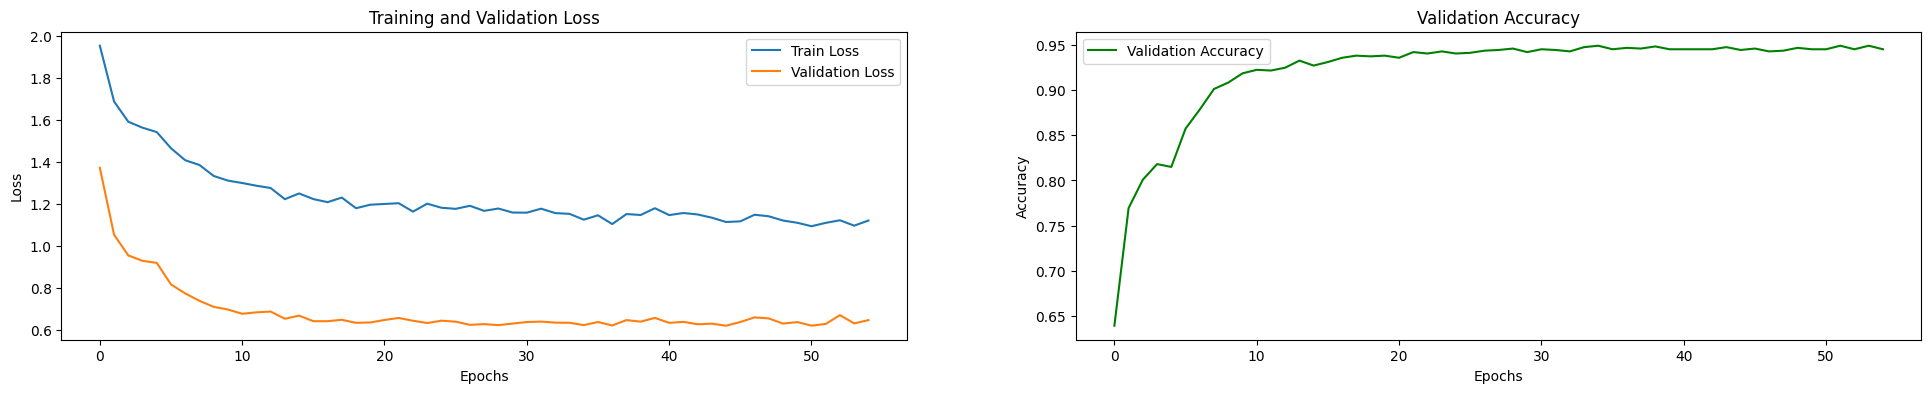

      Metric     Value
0   Accuracy  0.933022
1  Precision  0.927792
2     Recall  0.920348
3   F1-score  0.922630
  Class  Precision    Recall
0    BT   0.970464  0.931174
1    LT   0.979167  0.870370
2    MD   0.986175  0.986175
3    NC   0.883721  0.904762
4    NK   0.884146  0.788043
5   NNA   0.849206  0.972727
6   NNU   0.932945  0.987654
7    VT   0.936508  0.921875


In [17]:
trainer.training_plot()
trainer.evaluate_model(Data)

In [18]:
torch.save(trainer.model, "swin_ver1_28_4.pt")